### Theory

#### Hypothesis Testing – The problem of multiple comparisons [5 points]

##### Question A
On the first experiment ($m = 1$) the chance that the results are significant given that the experiment lacks the power to reject is equal to $\alpha$. On the second experiment it is equal to $\alpha * P(\text{We didn't reject experiment } m-1)$. So

$$P(m^{th} \text{ experiment is significant | } m \text{ experiments lacking power to reject } H_0) = (1 - \alpha)^{m-1} * \alpha$$

Example:

$\alpha = 0.05$

$m = 6$

$P(6^{th} \text{ experiment is significant | } 6 \text{ experiments lacking power to reject } H_0) = (1-0.05)^{6-1}*0.05 \approx 0.038$

#### Question B

There is an increased chance of finding at least one false significant finding the more tests you perform. If m independent comparisons are performed, the family wise error rate (FWER) can be used. The formula for the FWER is the following:

$$\alpha_{fw} = 1-(1-\alpha)^{m}$$

so

$$P(\text{ at least one significant result | } m \text{ experiments lacking power to reject } H_0) = \alpha_{fw}$$

To arrive at this result, observe that this is $1 - P(m \text{ insignificant results | } m \text{ experiments lacking power to reject } H_0)$

Example:

$\alpha = 0.05$

$m = 6$

$\alpha_{fw} = 1-(1-0.05)^6\approx0.26$

#### Bias and unfairness in Interleaving experiments [10 points]
Balance interleaving has been shown to be biased in a number of corner cases. An example was given during the lecture with two ranked lists of length 3 being interleaved, and a randomly clicking population of users that resulted in algorithm A winning ⅔ of the time, even though in theory the percentage of wins should be 50% for both algorithms. Can you come up with a situation of two ranked lists of length 3 and a distribution of clicks over them for which Team-draft interleaving is unfair to the better algorithm?

Ranking P

| D1 N |<br>
| D2 N |<br>
| D3 R |<br>

Ranking E

| D2 N |<br>
| D3 R |<br>
| D1 N |<br>

Because D3 is the only relevant document, we'd expect it's clicks to be attributed to E more often than to P.

The set of possible interleaved rankings using Team-Draft Interleaving is as follows:

| D1 N (P) | &emsp; | D1 N (P) | &emsp; | D2 N (E) | &emsp; | D2 N (E) | <br>
| D2 N (E) | &emsp; | D2 N (E) | &emsp; | D1 N (P) | &emsp; | D1 N (P) | <br>
| D3 R (P) | &emsp; | D3 R (E) | &emsp; | D3 R (P) | &emsp; | D3 R (E) | <br>

Where D3 is in the same position in all rankings, with equal assignments to P and E. Thus, in this case, the expected number of clicks is the same for both ranking functions even though ranking E should win. This is an example of insensitivy to the quality of rankings.

Example is based on: Hofmann, K., Whiteson, S., & De Rijke, M. (2011, October). A probabilistic method for inferring preferences from clicks. In Proceedings of the 20th ACM international conference on Information and knowledge management (pp. 249-258). ACM.

### Step 1: Simulate Rankings of Relevance for E and P 

In [182]:
import itertools
import numpy as np

# Added the numbers to facilitate easy sorting.
REL_SCORES = {'N' : 0, 'R' : 1, 'HR' : 2}

# Generate all possible rankings for both Production and Experimental systems
P = list(itertools.product(REL_SCORES.keys(), repeat = 5))
E = list(itertools.product(REL_SCORES.keys(), repeat = 5))
 
rankings = list(itertools.product(P, E))

# Make sure the right amount of combinations are made
assert len(rankings) == 3**10

# Show a sample of the generated rankings
for p, e in rankings[0::10000]:
    print(p)
    print(e)
    print()

('N', 'N', 'N', 'N', 'N')
('N', 'N', 'N', 'N', 'N')

('N', 'R', 'R', 'R', 'HR')
('N', 'R', 'R', 'N', 'R')

('R', 'N', 'N', 'N', 'R')
('N', 'HR', 'HR', 'N', 'HR')

('R', 'R', 'R', 'HR', 'N')
('R', 'R', 'N', 'R', 'N')

('HR', 'N', 'N', 'N', 'HR')
('R', 'HR', 'R', 'R', 'R')

('HR', 'R', 'R', 'HR', 'R')
('HR', 'N', 'HR', 'R', 'HR')



### Step 2: Implement Evaluation Measures

In [183]:
# quote from slide 15: "usually user only looks at very few top results : e.g. precision@3"
def precision_at_k(ranking, k):
    subset = ranking[:k]
    n_relevant = 0
    
    for result in subset:
        if REL_SCORES[result] > 0:
            n_relevant += 1
    
    return n_relevant / k

def DCG_at_k(ranking, k, optimal=False):
    subset = ranking[:k]
    
    if optimal:
        subset = sorted(subset, reverse=True, key=lambda x: REL_SCORES[x])
        
    discounted_score = 0
    
    for i, result in enumerate(subset):
        # prepare variables for DCG formula
        rank = i + 1
        rel = REL_SCORES[result]
        
        # Calculate score
        score = (2**rel - 1) / np.log2(1 + rank)
        discounted_score += score
    
    # NB: sum is part of the formula
    return discounted_score
        
def nDCG_at_k(ranking, k):
    true = DCG_at_k(ranking, k)
    best = DCG_at_k(ranking, k, optimal=True)
    
    # This is to prevent dividing by 0. If the best possible DCG is 0, the
    # true DCG is also zero (because there are no relevant document is the top k)
    if best == 0.0: 
        return 0.0
    else:
        return true / best

def prob_of_relevance(grade, max_grade):
    return (2**grade - 1) / 2**max_grade

def ERR(ranking):
    """Algorithm to compute ERR in linear time, implemented based on 
    
    Chapelle, O., Metlzer, D., Zhang, Y., & Grinspan, P. (2009, November). 
    Expected reciprocal rank for graded relevance. In Proceedings of the 18th ACM conference
    on Information and knowledge management (pp. 621-630). ACM."""
    
    grades = [REL_SCORES[x] for x in ranking]
    max_grade = max(REL_SCORES.values())
    
    p = 1
    err = 0
    
    for r in range(len(grades)):
        R = prob_of_relevance(grades[r], max_grade)
        err += p * (R/(r+1))
        p *= (1 - R)
    
    return err

In [184]:
## This cell does te calculations for all three metrics and saves the results to a list    

depth = 3

precision_p = []
precision_e = []
dcg_p = []
dcg_e = []
err_p = []
err_e = []

for i, (p, e) in enumerate(list(rankings)):
    precision_p.append(precision_at_k(p, depth))
    precision_e.append(precision_at_k(e, depth))

    dcg_p.append(nDCG_at_k(p, depth))
    dcg_e.append(nDCG_at_k(e, depth))
    
    err_p.append(ERR(p))
    err_e.append(ERR(e))

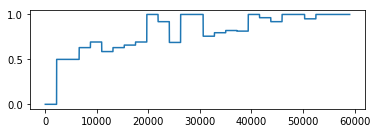

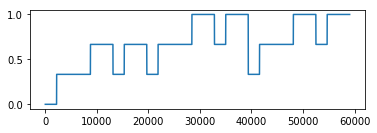

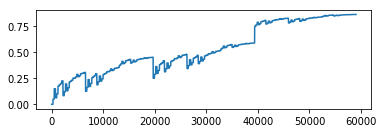

In [185]:
import matplotlib.pyplot as plt

plt.figure(1)
plt.subplot(211)
plt.plot(range(len(dcg_p)), dcg_p)

# plt.subplot(212)
# plt.plot(range(len(dcg_e)), dcg_e, linewidth=0.1)

plt.figure(2)
plt.subplot(211)
plt.plot(range(len(precision_p)), precision_p)

# plt.subplot(212)
# plt.plot(range(len(precision_e)), precision_e, linewidth=0.1)

fig = plt.figure(3)
plt.subplot(211)
plt.plot(range(len(err_p)), err_p)

# plt.subplot(212)
# plt.plot(range(len(err_e)), err_e, linewidth=0.1)

plt.show()


#TODO: asxislabels, graphtitles
#TODO: Analsyse algemener maken. De volgorde van R / N / HR is anders op elke machine

### Analysis

The lists in the `rankings` variable represents a simulation of all possible outcomes of a comparisson of model P and model E on a query. Because of the way the combinations are generated, subsequent instances of the E model vary rapidly and thus produce chaotic graphs. So for the graphical analysis, we will focus on model P.

The first thing that stands out is that there is no obvious pattern in the progression of the metrics as you iterate trough the instances. We would've expected a more symmectric shape of the plot. But at further inspection, there is indeed a pattern. This is especially viable when you compare the three metrics with eachoter. All metrics are mininum around the 30.000th pair, which where the rankings are mostly non-relevant. At the beginning and end of the simulations the rankings are made up of mostly 'R' and 'HR' documents so they score high. In the EGG chart you get a more detailed view, since the grade of the rank is taken into account and grade('R') < grade('HR').

### Step 3: Calculate the 𝛥measure

In [186]:
# In the assignment is says to only consider pairs for which E > P. But we found it easier to keep
# all pairs, because we have to compare the results with the online rankings. If we discard some pairs,
# the arrays don't line up anymore.

def delta_measure(scores_a, scores_b):
    return [b - a for a, b in zip(scores_a, scores_b)]

def percentage_of_wins_for_E(delta_values):
    return np.sum(np.array(delta_values) > 0) / len(delta_values)

# Calculate delta measure for the three chosen metrics
delta_precision = delta_measure(precision_p, precision_e)
delta_nDCG = delta_measure(dcg_p, dcg_e)
delta_ERR = delta_measure(err_p, err_e)

print("A subset of delta precisions")
print()
print(delta_precision[0::1000])
print()
print("percentage of wins for E:", percentage_of_wins_for_E(delta_precision))
print()
print()
print("A subset of delta nDCGs")
print()
print(delta_nDCG[0::1000])
print()
print("Percentage of wins for E:", percentage_of_wins_for_E(delta_nDCG))
print()
print()
print("A subset of delta ERRs")
print()
print(delta_ERR[0::1000])
print()
print("Percentage of wins for E:", percentage_of_wins_for_E(delta_ERR))

A subset of delta precisions

[0.0, 0.3333333333333333, 0.3333333333333333, 0.0, 0.3333333333333333, 0.3333333333333333, 0.0, 0.3333333333333333, 0.3333333333333333, -0.3333333333333333, 0.0, 0.0, 0.0, 0.33333333333333337, 0.6666666666666667, 0.3333333333333333, 0.33333333333333337, 0.33333333333333337, -0.3333333333333333, 0.0, 0.3333333333333333, 0.3333333333333333, 0.33333333333333337, 0.33333333333333337, 0.0, 0.33333333333333337, 0.33333333333333337, -0.3333333333333333, -0.3333333333333333, -0.6666666666666667, -0.33333333333333337, -0.33333333333333337, -0.6666666666666667, 0.0, 0.0, -1.0, -0.33333333333333337, -0.33333333333333337, -0.33333333333333337, 0.0, 0.6666666666666667, 0.3333333333333333, 0.33333333333333337, 0.33333333333333337, -0.3333333333333333, 0.0, 0.0, 0.0, 0.33333333333333337, 0.0, -0.33333333333333337, 0.0, 0.0, -0.3333333333333333, -0.3333333333333333, -0.6666666666666667, -0.33333333333333337, -0.33333333333333337, -0.6666666666666667, -0.33333333333333337]

### Step 4:  Implement Interleaving

In [187]:
import random

# Use a seed to ensure the tests can be replicated
random.seed(100)

def balanced_interleaving(A,B):

    # initialize pointers p_a and p_b
    p_a, p_b, I = 0, 0, []

    # Flip a coin to decide which pointer to pick highest value from ranking
    turn = 'A' if random.randint(0, 1) == 0 else 'B'

    # Greedily collect rankings from both lists and build the interleaved list,
    # while there are still documents not present in the interleaved list
    while p_a < len(A) and p_b < len(B):
        if p_a < p_b or p_a == p_b and turn == 'A':
            if A[p_a] not in I:
                I.append(A[p_a])
            p_a += 1
        else:
            if B[p_b] not in I:
                I.append(B[p_b])
            p_b += 1
    return(I[:5])
            
balanced_interleaved_lists = []

# Generate all interleaved lists
for A,B in rankings:
    A, B = [str(a) + "P" + str(i) for i, a in enumerate(A)], [str(b) + "E" + str(i) for i, b in enumerate(B)]
    interleaved_list = balanced_interleaving(A,B)
    balanced_interleaved_lists.append(interleaved_list)
print('a subset of the balanced interleaved lists: ', balanced_interleaved_lists[:5] )

a subset of the balanced interleaved lists:  [['NP0', 'NE0', 'NP1', 'NE1', 'NP2'], ['NE0', 'NP0', 'NE1', 'NP1', 'NE2'], ['NE0', 'NP0', 'NE1', 'NP1', 'NE2'], ['NP0', 'NE0', 'NP1', 'NE1', 'NP2'], ['NE0', 'NP0', 'NE1', 'NP1', 'NE2']]


In [188]:
def team_draft_interleaving(A,B):
    # create teams
    team_a, team_b, I = 0, 0, []
    
    # While there are still documents not present in the interleaved list
    while any(set(A)-set(I)) and any(set(B)-set(I)):
        
        #Flip a coin
        turn = 'A' if random.randint(0, 1) == 0 else 'B'
        
        #If A wins the coin flip: put the highest ranked document of A
        # that is not yet in the interleaved list, in the interleaved
        if team_a < team_b or team_a == team_b and turn == 'A':
            for a in A:
                if a not in I:
                    I.append(a)
                    break
            team_a += 1
        # If B wins the flip: put the highest ranked document of A
        # that is not yet in the interleaved list, in the interleaved
        else:
            for b in B:
                if b not in I:
                    I.append(b)
                    break
            team_b += 1
    return(I[:5])



team_interleaved_lists = []

# Generate all interleaved lists
for A,B in rankings:
    A, B = [str(a) + "P" + str(i) for i, a in enumerate(A)], [str(b) + "E" + str(i) for i, b in enumerate(B)]
    interleaved_list = team_draft_interleaving(A,B)
    team_interleaved_lists.append(interleaved_list)
    
print('a subset of the balanced interleaved lists: ', team_interleaved_lists[:5] )

a subset of the balanced interleaved lists:  [['NP0', 'NE0', 'NP1', 'NE1', 'NP2'], ['NP0', 'NE0', 'NP1', 'NE1', 'NP2'], ['NP0', 'NE0', 'NE1', 'NP1', 'NE2'], ['NP0', 'NE0', 'NP1', 'NE1', 'NE2'], ['NP0', 'NE0', 'NE1', 'NP1', 'NP2']]


### Step 5:  Implement User Clicks Simulation

In [189]:
''' In this cell the Random click model is implemented. We use the PyClick module to parse the Yandex file.
Our TA assured us it is fine, if we use it just for the parsing of the Yandex file.
Furthermore we assume all queries should be used, even if none of the results are clicked'''

def execute_clicks(click_probs):
    """Returns a list of booleans indicating on which positions was clicked, based on the
    given click_probs (click probabilities)"""
    
    # Flip one coin for (and with) every probability in click_probs
    return np.random.binomial(1, p=click_probs)

def MLE_random_click(sessions):
    '''As slide 62 of lecture 3 shows, the MLE of a bernouilli distribution, rho, is just
    the ratio of clicks with respect to the total number of URls shown. 
    '''
    total_clicks = 0
    total_shown = len(sessions)*10
    
    for sesh in sessions:
        total_clicks += sum(sesh.get_clicks())
    
    rho = total_clicks/total_shown
    return rho
            
def random_click_probabilities(ranking, rho):
    '''probabilities of a click from the random clicking model'''
    return [rho] * len(ranking)

def simulate_random_click_model(ranking, rho, N):
    '''Generate N click patterns based on the random click model'''
    return [execute_clicks(random_click_probabilities(ranking, rho)) for _ in range(N)]

def sdbn_click_probabilities(ranking, alphas, sigmas):
    '''Probabilities of a click from the Simple Bayesian Dynamic Network'''
    
    # Assume zero probabilities
    click_probs = [0.0] * len(ranking)
    
    for i, relevance in enumerate(ranking):
        
        # Click when attracted
        alpha = alphas[relevance[:-2]]
        click_probs[i] = alpha
        
        # If satisfied, we do not evaluate the rest of the documents
        satisfied = float(np.random.choice([0,1], 1, p=[(1-sigmas[i]),(sigmas[i])]))
        if satisfied:
            break
    
    return click_probs

def simulate_sdbn_click_model(ranking, alphas, sigmas, N):
    '''Generate N click patterns based on the SDBN click model'''
    return [execute_clicks(sdbn_click_probabilities(ranking, alphas, sigmas)) for _ in range(N)]

In [190]:
import pyclick
from pyclick.utils import YandexRelPredChallengeParser

parser = YandexRelPredChallengeParser.YandexRelPredChallengeParser()
search_sessions = parser.parse('YandexRelPredChallenge.txt')

For the Simple Dynamic Bayesian Network click model we learn the satisfaction parameter $\sigma_{u_rq}$, meaning we learn the satisfaction for each query and the document ID that was clicked last. The Maximum Likelihood estimation for the satisfaction becomes: 

<center>
    
$\sigma_{u_rq} = \frac{l_{u_rq}}{T_{u_rq}}$, 
</center>

where $l_{u_rq}$ is the count of events the document ID was clicked last given the query and $T_{u_rq}$ represents the total number of times the document ID was clicked for the query.

We are assuming that the document IDs are ranked deterministically, meaning that the query will always output the same 10 document IDs in the same order. This assumption allows us to discard the document ID information, and instead keep rank indication of a click given the query.

The resulting matrix consists of n-queries by 10-ranks, where each element carries the satisfaction parameter of a rank given the query. As query-rank satisfaction parameters are not useful to our relevance rankings, we need to estimate a general satisfaction parameter for each rank. We do this by calculating the mean of satisfaction parameters for all queries given a rank. This leaves us with a 1 by 10 vector; an average satisfaction parameter per rank.

In [191]:
# Assumption: 1 query always returns the same docIDs (ie. ranking is deterministic)
# TODO: dit kunnen we in principe gewoon testen

from collections import Counter

def learn_sdbn_satisfaction(search_sessions):
    last_click_ranks = dict()
    clicks_per_query = dict()
    last_total_ratio = dict()

    # Find last click rank per query:
    for session in search_sessions:
        
        # If get_last_click_rank returns 10, there hasn't been click action for the query.
        if session.get_last_click_rank() == 10:
            continue

        # Find last click:
        if session.query in last_click_ranks:
            last_click_ranks[session.query].append(session.get_last_click_rank())
        else:
            last_click_ranks[session.query] = [session.get_last_click_rank()]
            
        # Find all click ranks per query:
        if session.query not in clicks_per_query:
            clicks_per_query[session.query] = []

        for idx, val in enumerate(session.get_clicks()):
            if val == 1:
                clicks_per_query[session.query].append(idx)    

    # Calculate sigmas for each unique query and each of its ranks:
    for query in last_click_ranks.keys():
        last_total_ratio[query] = [0] * 10
    
        count_last = Counter(last_click_ranks[query])
        count_total = Counter(clicks_per_query[query])
    
        for rank in list(count_last):
            sigma = count_last[rank] / count_total[rank]
            
            last_total_ratio[query][rank] = sigma
            
    # Compose final list of average sigmas, i.e. 1 sigma for each rank:
    avg_sigmas = [0.0] * 10

    for query in list(last_total_ratio):
        avg_sigmas = [sum(sigma) for sigma in zip(last_total_ratio[query], avg_sigmas)]
    
    click_model = [sigma / len(last_total_ratio) for sigma in avg_sigmas]
    norm_click_model = [float(sigma) / sum(click_model) for sigma in click_model]
    
    return last_click_ranks, clicks_per_query, last_total_ratio, click_model, norm_click_model


%time last, total, sigmas, cm, ncm = learn_sdbn_satisfaction(search_sessions)
# np.sum(sigmas, axis=1)

CPU times: user 368 ms, sys: 4 ms, total: 372 ms
Wall time: 371 ms


In [192]:
print(sorted(last["209"]))
print()
print(sorted(total["209"]))
print()
print(sigmas["209"])

ncm

[0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 4, 4, 4, 5, 5, 5, 5, 5, 5, 6, 7, 7, 7, 7, 9, 9, 9, 9]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 6, 7, 7, 7, 7, 7, 8, 9, 9, 9, 9]

[0.16666666666666666, 0.23809523809523808, 0.5714285714285714, 0.2, 1.0, 0.75, 1.0, 0.8, 0, 1.0]


[0.3018946437863322,
 0.13935807899762456,
 0.10099568029438585,
 0.07764684930525055,
 0.0668552341376478,
 0.05735932604177672,
 0.052778979230879736,
 0.05392186789369821,
 0.056920170277655065,
 0.0922691700347493]

### Step 6: Simulate Interleaving Experiment

In [193]:
'''Random click model experiment'''

def experiment_team(clicks, interleaved_list):
    '''Does experiments for one interleaved list with a list of click patterns.
    Outputs a proportion of wins for E over all experiments, ties included.'''
    
    clicks = np.array(clicks)
    
    # Boolean array where each contribution of E is marked True
    E_docs = np.array([x[-2] == 'E' for x in interleaved_list])
    
    # Overlay of clicks and the boolean mask above. Evaluates
    # to True if a rank has been clicked and was contributed by E.
    # Finally sum those Truths (1s) to get total clicks on E per experiment
    E_clicks = np.sum(np.logical_and(E_docs, clicks), axis=1)
    
    # Clicks on P are the difference of total clicks and E-clicks
    P_clicks = np.sum(clicks, axis=1) - E_clicks
    
    return  np.sum(E_clicks > P_clicks) / len(clicks)

def experiment_balanced(clicks, interleaved_list):
    '''Does experiments for one interleaved list with a list of click patterns.
    Outputs a proportion of wins for E over all experiments, ties included.'''
    
    
    clicks = np.array(clicks)
    
    # Boolean array where each contribution of E is marked True
    E_docs = np.array([x[-2] == 'E' for x in interleaved_list])
    
    # Overlay of clicks and the boolean mask above. Evaluates
    # to True if a rank has been clicked and was contributed by E.
    # Finally sum those Truths (1s) to get total clicks on E per experiment
    E_clicks = np.sum(np.logical_and(E_docs, clicks), axis=1)
    
    # Clicks on P are the difference of total clicks and E-clicks
    P_clicks = np.sum(clicks, axis=1) - E_clicks
    
    return  np.sum(E_clicks > P_clicks) / len(clicks)

In [ ]:
'''In this cell the experiment for the random click model and the SBBN are run'''

E_win_proportions = {
    'random_balanced' : [],
    'sdbn_balanced' : [],
    'random_team' : [],
    'sdbn_team' : []
}

# Estimate alpha_uq from relevance labels

# Katja Hofmann, Anne Schuth, Shimon Whiteson, and Maarten de Rijke. Reusing historical interaction
# data for faster online learning to rank for IR. In WSDM, 2013. ACM Press. 69, 70, 77

alpha = {
    'perfect' : {'N' : 0.0, 'R' : 0.5, 'HR' : 1.0},
    'navigational' : {'N' : 0.05, 'R' : 0.5, 'HR' : 0.95},
    'informal' : {'N' : 0.4, 'R' : 0.7 , 'HR' : 0.9}
}

# Calculate the Rho for the random click model
rho = MLE_random_click(search_sessions)

import time

N = 100
start = time.time()
for i in range(len(balanced_interleaved_lists)):
    if i % 100 == 0 and i > 0:
        print("{} / {} \t\t at {}/sec".format(i+1, len(balanced_interleaved_lists), (i+1)/(time.time() - start)))
    
    # Random Click Model simulation
    random_clicks = simulate_random_click_model(balanced_interleaved_lists[i], rho, N)
    E_win_proportions['random_balanced'].append(experiment(random_clicks, balanced_interleaved_lists[i]))
    
    random_clicks = simulate_random_click_model(team_interleaved_lists[i], rho, N)
    E_win_proportions['random_team'].append(experiment(random_clicks, team_interleaved_lists[i]))
    
    # SDBN simulation
    sdbn_clicks = simulate_sdbn_click_model(balanced_interleaved_lists[i], alpha['navigational'], ncm, N)
    E_win_proportions['sdbn_balanced'].append(experiment(sdbn_clicks, balanced_interleaved_lists[i]))
    
    sdbn_clicks = simulate_sdbn_click_model(team_interleaved_lists[i], alpha['navigational'], ncm, N)
    E_win_proportions['sdbn_team'].append(experiment(sdbn_clicks, team_interleaved_lists[i]))

101 / 59049 		 at 146.18066752635394/sec
201 / 59049 		 at 133.4509837132375/sec
301 / 59049 		 at 137.82297933362997/sec
401 / 59049 		 at 136.9927180901576/sec
501 / 59049 		 at 137.08041804398584/sec
601 / 59049 		 at 138.58620118836237/sec
701 / 59049 		 at 140.11063500147915/sec
801 / 59049 		 at 141.825591254901/sec
901 / 59049 		 at 142.94156363383834/sec
1001 / 59049 		 at 144.0405510766937/sec
1101 / 59049 		 at 144.76215157997413/sec
1201 / 59049 		 at 144.32142149073258/sec
1301 / 59049 		 at 143.81939277305108/sec
1401 / 59049 		 at 143.51915944491816/sec
1501 / 59049 		 at 143.64850234353327/sec
1601 / 59049 		 at 142.808441610711/sec
1701 / 59049 		 at 142.53114307121822/sec
1801 / 59049 		 at 142.4252673808109/sec
1901 / 59049 		 at 143.11829914105923/sec
2001 / 59049 		 at 143.6126312140962/sec
2101 / 59049 		 at 143.92066084949883/sec
2201 / 59049 		 at 144.23176640912993/sec
2301 / 59049 		 at 144.6436124277559/sec
2401 / 59049 		 at 144.95002124191782/sec
2501 / 5904

19601 / 59049 		 at 138.76064501742968/sec
19701 / 59049 		 at 138.69866685077466/sec
19801 / 59049 		 at 138.6534242084074/sec
19901 / 59049 		 at 138.55692018678704/sec
20001 / 59049 		 at 138.4332692041812/sec
20101 / 59049 		 at 138.32367577540697/sec
20201 / 59049 		 at 138.18675465930602/sec
20301 / 59049 		 at 138.09911538379367/sec
20401 / 59049 		 at 137.9493876137846/sec
20501 / 59049 		 at 137.7066879128977/sec
20601 / 59049 		 at 137.66067974932113/sec
20701 / 59049 		 at 137.59166442895676/sec
20801 / 59049 		 at 137.53736642753785/sec
20901 / 59049 		 at 137.51494652553697/sec
21001 / 59049 		 at 137.50875861145795/sec
21101 / 59049 		 at 137.4870713891963/sec
21201 / 59049 		 at 137.492932215846/sec
21301 / 59049 		 at 137.54095678726787/sec
21401 / 59049 		 at 137.60158028299836/sec
21501 / 59049 		 at 137.57271173107296/sec
21601 / 59049 		 at 137.56712307649556/sec
21701 / 59049 		 at 137.52991489139936/sec
21801 / 59049 		 at 137.5823034388544/sec
21901 / 59049 		 at

38801 / 59049 		 at 137.0341111130049/sec
38901 / 59049 		 at 137.06174348430937/sec
39001 / 59049 		 at 137.08556237972883/sec
39101 / 59049 		 at 137.0997916648704/sec
39201 / 59049 		 at 137.09726656964583/sec
39301 / 59049 		 at 137.12534553618826/sec
39401 / 59049 		 at 137.15686526096056/sec
39501 / 59049 		 at 137.18823398651347/sec
39601 / 59049 		 at 137.21049642140267/sec
39701 / 59049 		 at 137.22376814476945/sec
39801 / 59049 		 at 137.23443809934125/sec
39901 / 59049 		 at 137.23389295835943/sec
40001 / 59049 		 at 137.17244348817906/sec
40101 / 59049 		 at 137.1690485045989/sec
40201 / 59049 		 at 137.10943333563554/sec
40301 / 59049 		 at 137.05955340858014/sec
40401 / 59049 		 at 137.02580288982853/sec
40501 / 59049 		 at 136.9814153036857/sec
40601 / 59049 		 at 136.91767789094988/sec
40701 / 59049 		 at 136.85244164281875/sec
40801 / 59049 		 at 136.8041621008834/sec
40901 / 59049 		 at 136.7893565045663/sec
41001 / 59049 		 at 136.80166896665398/sec


### Step 7: Analysis

In [194]:
import pickle
#pickle.dump(E_win_proportions, open( "e_win_proportions_N100.p", "wb" ) )

E_win_proportions = pickle.load(open("e_win_proportions_N100.p", 'rb'))

To be able to do a t-test we must first confirm that the data follows a normal distribution. For this purpose the Omnibus test by D'agostino and Pearson is used. The experimental data is generated with an N=100, meaning 100 experiments for all interleaved rankings per click model are simulated.

(D’Agostino, R. and Pearson, E. S. (1973), “Testing for departures from normality,” Biometrika, 60, 613-622)

In [195]:
import random
import scipy.stats as stats

# Test if data is normaliy distributed
print('For the sdbn the normality test gives a p-value of 0.0, meaning that (using an alpha of 0.05) the hypothesis that the distibution of the data comes from a normal distribution is rejected:\n\n ',stats.mstats.normaltest(E_win_proportions['sdbn'], axis=0))
print('\n')
print('The same holds for data generated by the random click model: \n\n',stats.mstats.normaltest(E_win_proportions['random'], axis=0))
print('\n\n For both clickmodels it thus does not make sense to use a t-test')

KeyError: 'sdbn'

### Testing methodology

In the paper "Large-Scale Validation and Analysis of Interleaved Search Evaluation" it is mentioned that non-parametric significance tests like bootstrap methods require fewer assumptions. The above test of normality gives an indication why this can be important (e.g. doing a t-test wouldn't make sense in the abov. Following the paper we also addopt a bootstrapping method to compare the online and offline evaluations. We try to do that by assessing if the expert evaluations match with the online evalutations. As mentioned in the paper "Agreement between expert judgments and interleaving builds confidence that both methods accurately reflect user satisfaction with search result". However, one must keep in mind that this is still no guarantee.

In [205]:
def datasampler(nr_samples):
    
    # Sorry guys: don't get confused by ambiguous variable names...
    
    ranking_sample_nrs = []
    

    # Generate unique random ints between 0 and len(rankings)
    while len(ranking_sample_nrs) < nr_samples:
        sample = random.randint(0, len(rankings) - 1)
        if sample not in ranking_sample_nrs:
            ranking_sample_nrs.append(sample) 

    # Initialize a massive dictionary to make analyses simple
    experiment = {
        "nr_samples" : nr_samples,
        "ranking_idx" : ranking_sample_nrs,
        "ranking_pairs" : [],
        "precision_p" : [],
        "precision_e" : [],
        "d_precision" : [],
        "dcg_p" : [],
        "dcg_e" : [],
        "d_dcg" : [],
        "err_p" : [],
        "err_e" : [],
        "d_err" : [],
        "offline_depth" : depth,
        "offline_wins" : {
            "precision" : 0.0,
            "dcg" : 0.0,
            "err" : 0.0,
        },
        "team" : {
            "interleaved" : [],
            "random_prop" : [],
            "sdbn_prop" : [],
            "wins_random" : 0,
            "wins_sdbn" : 0
        },
        "balanced" : {
            "interleaved" : [],
            "random_prop" : [],
            "sdbn_prop" : [],
            "wins_random" : 0,
            "wins_sdbn" : 0
        },
    }

    # Collect all data from the notebook:
    for idx in ranking_sample_nrs:
        experiment["ranking_pairs"].append(rankings[idx])
        experiment["precision_p"].append(precision_p[idx])
        experiment["precision_e"].append(precision_e[idx])
        experiment["d_precision"].append(delta_precision[idx])
        experiment["dcg_p"].append(dcg_p[idx])
        experiment["dcg_e"].append(dcg_e[idx])
        experiment["d_dcg"].append(delta_nDCG[idx])
        experiment["err_p"].append(err_p[idx])
        experiment["err_e"].append(err_e[idx])
        experiment["d_err"].append(delta_ERR[idx])
        
        
        # Get from all global variables in the notebook and store in dict:
        experiment["team"]["interleaved"].append(team_interleaved_lists[idx])
        experiment["team"]["random_prop"].append(E_win_proportions['random_team'][idx])
        experiment["team"]["sdbn_prop"].append(E_win_proportions['sdbn_team'][idx])
        
        experiment["balanced"]["interleaved"].append(balanced_interleaved_lists[idx])
        experiment["balanced"]["random_prop"].append(E_win_proportions['random_balanced'][idx])
        experiment["balanced"]["sdbn_prop"].append(E_win_proportions['sdbn_balanced'][idx])

    # Derive from dict entries:
    experiment["offline_wins"]["precision"] = percentage_of_wins_for_E(experiment["d_precision"])
    experiment["offline_wins"]["dcg"] = percentage_of_wins_for_E(experiment["d_dcg"])
    experiment["offline_wins"]["err"] = percentage_of_wins_for_E(experiment["d_err"])

    experiment["team"]["wins_random"] = np.mean(experiment["team"]["random_prop"])
    experiment["team"]["wins_sdbn"] = np.mean(experiment["team"]["sdbn_prop"])    
    experiment["balanced"]["wins_random"] = np.mean(experiment["balanced"]["random_prop"])    
    experiment["balanced"]["wins_sdbn"] = np.mean(experiment["balanced"]["sdbn_prop"])
    
    return experiment
    

In [212]:
import matplotlib.pyplot as plt

# Rounding method, allowing us to round at 0.005 level
def myround(x, prec=3, base=.005):
    return round(base * round(float(x)/base),prec)

myround(round(0.8034598076, 3))


# Initialize a massive dictionary to make analyses simple
bootstrapping_data = {
    "offline_wins" : {
        "precision" : Counter(),
        "dcg" : Counter(),
        "err" : Counter()
    },
    "team" : {
        "wins_random" : Counter(),
        "wins_sdbn" : Counter(),
    },
    "balanced" : {
        "wins_random" : Counter(),
        "wins_sdbn" : Counter()
    },
}

# bootstrapping_data = {"offline_wins": Counter(), "team": Counter(), "balanced": Counter()}
for i in range(10000):
    experiment_result = datasampler(200)

    bootstrapping_data["offline_wins"]["precision"][myround(round(experiment_result["offline_wins"]["precision"], 3))]+=1 
    bootstrapping_data["offline_wins"]["dcg"][myround(round(experiment_result["offline_wins"]["dcg"], 3))] +=1
    bootstrapping_data["offline_wins"]["err"][myround(round(experiment_result["offline_wins"]["err"], 3))]+=1 
    bootstrapping_data["team"]["wins_random"][myround(round(experiment_result["team"]["wins_random"], 3))] +=1 
    bootstrapping_data["team"]["wins_sdbn"][myround(round(experiment_result["team"]["wins_sdbn"], 3))]+=1 
    bootstrapping_data["balanced"]["wins_random"][ myround(round(experiment_result["balanced"]["wins_random"], 3))]+=1
    bootstrapping_data["balanced"]["wins_sdbn"][myround(round(experiment_result["balanced"]["wins_sdbn"], 3))]+=1 



In [147]:
pickle.dump(bootstrap_data, open( "bootstrap_data_N100.p", "wb" ) )

0.31999999999999995

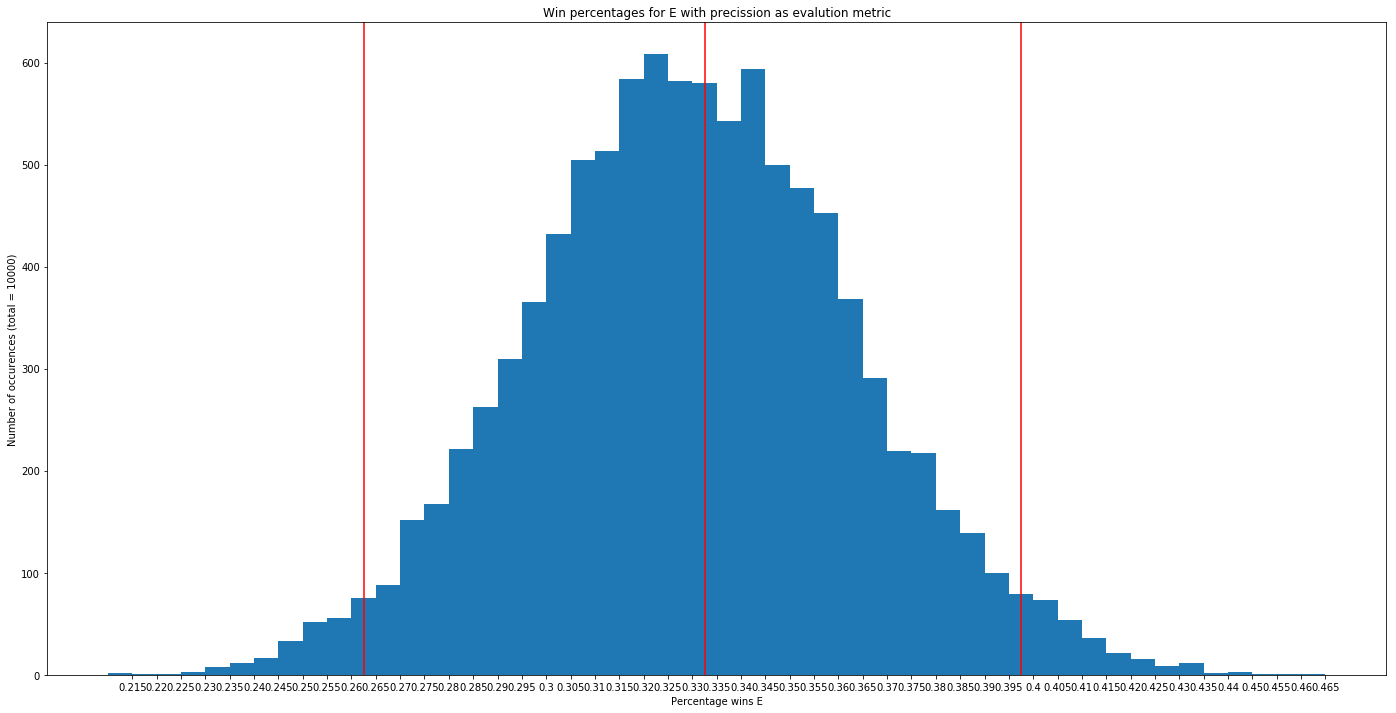

95.0 confidence interval 26.5% and 40.0%, with mean at 0.333


In [230]:
fig, ax = plt.subplots(figsize=(24, 12))


# Create graph attributes:
stats = list(bootstrapping_data["offline_wins"]["precision"].elements())

alpha = 0.95
p = ((1.0-alpha)/2.0) * 100
lower = max(0.0, np.percentile(stats, p))
p = (alpha+((1.0-alpha)/2.0)) * 100
upper = min(1.0, np.percentile(stats, p))
mean = np.mean(stats)
mean_idx = sorted(list(bootstrapping_data["offline_wins"]["precision"].keys())).index(myround(round(mean, 3)))
lower_idx = sorted(list(bootstrapping_data["offline_wins"]["precision"].keys())).index(myround(round(lower, 3)))
upper_idx = sorted(list(bootstrapping_data["offline_wins"]["precision"].keys())).index(myround(round(upper, 3)))

labels, values = zip(*sorted(bootstrapping_data["offline_wins"]["precision"].items()))

indexes = np.arange(len(labels))
width = 1

plt.axvline(mean_idx, color='r')
plt.axvline(lower_idx, color='r')
plt.axvline(upper_idx, color='r')

plt.bar(indexes, values, width)
plt.xticks(indexes + width * 0.5, labels)


ax.set_xlabel('Percentage wins E') 
ax.set_ylabel('Number of occurences (total = 10000)')
ax.set_title('Win percentages for E with precission as evalution metric')
plt.show()
print('%.1f confidence interval %.1f%% and %.1f%%, with mean at %.3f' % (alpha*100, lower*100, upper*100, mean))

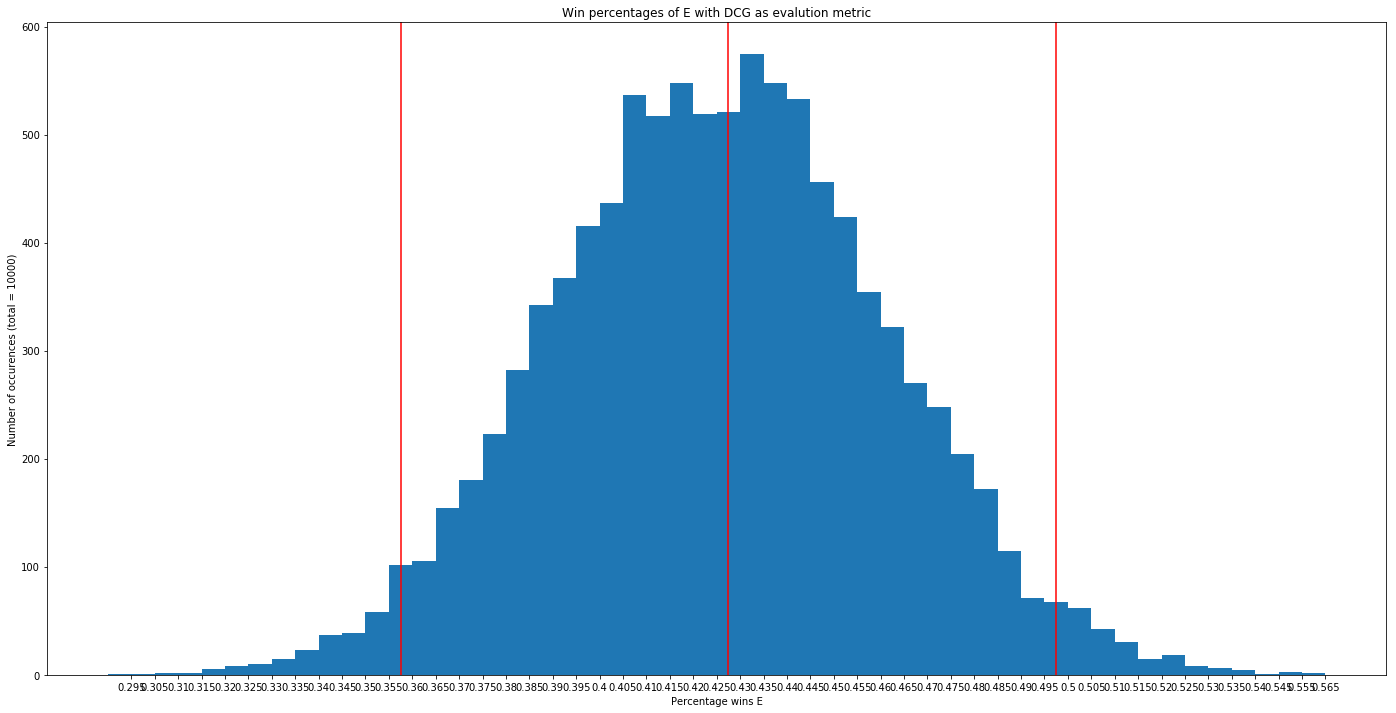

95.0 confidence interval 36.0% and 50.0%, with mean at 0.428


In [231]:
fig, ax = plt.subplots(figsize=(24, 12))


# Create graph attributes:
stats = list(bootstrapping_data["offline_wins"]["dcg"].elements())

alpha = 0.95
p = ((1.0-alpha)/2.0) * 100
lower = max(0.0, np.percentile(stats, p))
p = (alpha+((1.0-alpha)/2.0)) * 100
upper = min(1.0, np.percentile(stats, p))
mean = np.mean(stats)
mean_idx = sorted(list(bootstrapping_data["offline_wins"]["dcg"].keys())).index(myround(round(mean, 3)))
lower_idx = sorted(list(bootstrapping_data["offline_wins"]["dcg"].keys())).index(myround(round(lower, 3)))
upper_idx = sorted(list(bootstrapping_data["offline_wins"]["dcg"].keys())).index(myround(round(upper, 3)))

labels, values = zip(*sorted(bootstrapping_data["offline_wins"]["dcg"].items()))

indexes = np.arange(len(labels))
width = 1

plt.axvline(mean_idx, color='r')
plt.axvline(lower_idx, color='r')
plt.axvline(upper_idx, color='r')

plt.bar(indexes, values, width)
plt.xticks(indexes + width * 0.5, labels)


ax.set_xlabel('Percentage wins E') 
ax.set_ylabel('Number of occurences (total = 10000)')
ax.set_title('Win percentages of E with DCG as evalution metric')
plt.show()
print('%.1f confidence interval %.1f%% and %.1f%%, with mean at %.3f' % (alpha*100, lower*100, upper*100, mean))

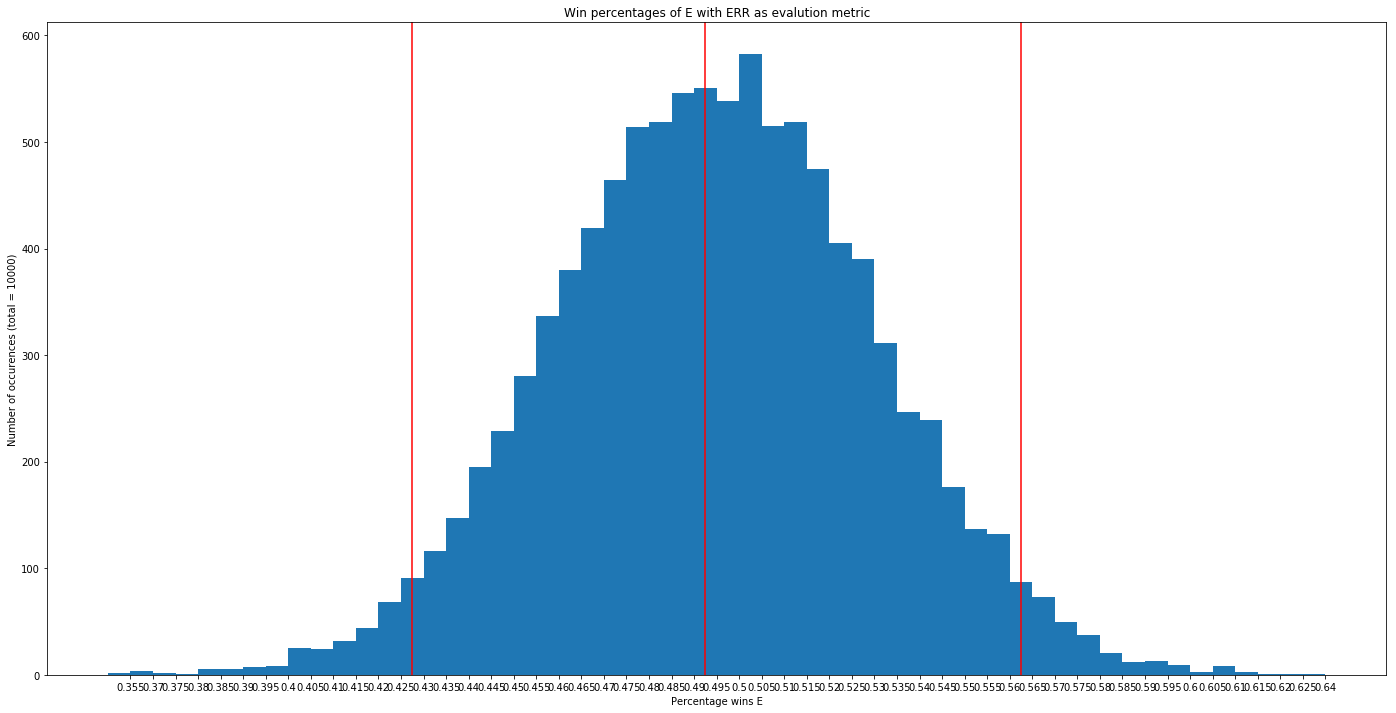

95.0 confidence interval 43.0% and 56.5%, with mean at 0.497


In [232]:
fig, ax = plt.subplots(figsize=(24, 12))


# Create graph attributes:
stats = list(bootstrapping_data["offline_wins"]["err"].elements())

alpha = 0.95
p = ((1.0-alpha)/2.0) * 100
lower = max(0.0, np.percentile(stats, p))
p = (alpha+((1.0-alpha)/2.0)) * 100
upper = min(1.0, np.percentile(stats, p))
mean = np.mean(stats)
mean_idx = sorted(list(bootstrapping_data["offline_wins"]["err"].keys())).index(myround(round(mean, 3)))
lower_idx = sorted(list(bootstrapping_data["offline_wins"]["err"].keys())).index(myround(round(lower, 3)))
upper_idx = sorted(list(bootstrapping_data["offline_wins"]["err"].keys())).index(myround(round(upper, 3)))

labels, values = zip(*sorted(bootstrapping_data["offline_wins"]["err"].items()))

indexes = np.arange(len(labels))
width = 1

plt.axvline(mean_idx, color='r')
plt.axvline(lower_idx, color='r')
plt.axvline(upper_idx, color='r')

plt.bar(indexes, values, width)
plt.xticks(indexes + width * 0.5, labels)


ax.set_xlabel('Percentage wins E') 
ax.set_ylabel('Number of occurences (total = 10000)')
ax.set_title('Win percentages of E with ERR as evalution metric')
plt.show()
print('%.1f confidence interval %.1f%% and %.1f%%, with mean at %.3f' % (alpha*100, lower*100, upper*100, mean))

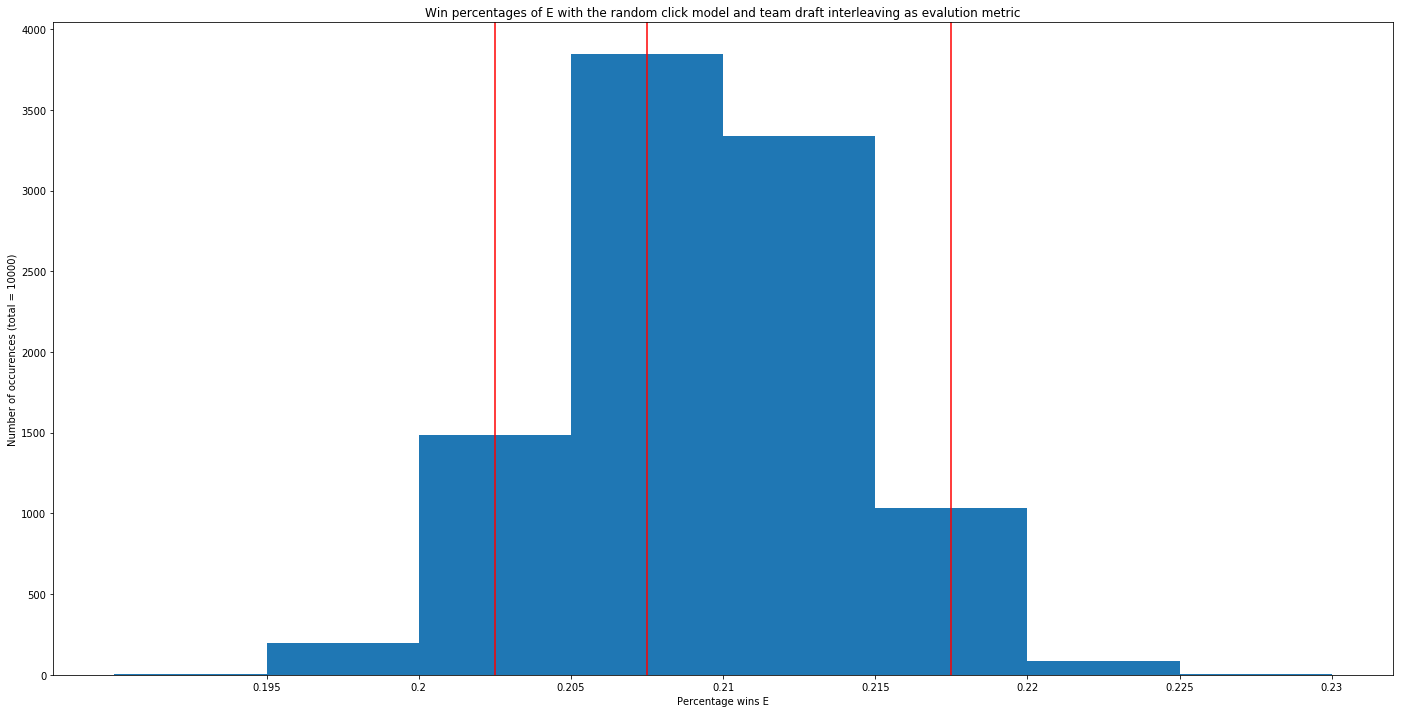

95.0 confidence interval 20.5% and 22.0%, with mean at 0.212


In [233]:
fig, ax = plt.subplots(figsize=(24, 12))


# Create graph attributes:
stats = list(bootstrapping_data["team"]["wins_random"].elements())

alpha = 0.95
p = ((1.0-alpha)/2.0) * 100
lower = max(0.0, np.percentile(stats, p))
p = (alpha+((1.0-alpha)/2.0)) * 100
upper = min(1.0, np.percentile(stats, p))
mean = np.mean(stats)
mean_idx = sorted(list(bootstrapping_data["team"]["wins_random"].keys())).index(myround(round(mean, 3)))
lower_idx = sorted(list(bootstrapping_data["team"]["wins_random"].keys())).index(myround(round(lower, 3)))
upper_idx = sorted(list(bootstrapping_data["team"]["wins_random"].keys())).index(myround(round(upper, 3)))

labels, values = zip(*sorted(bootstrapping_data["team"]["wins_random"].items()))

indexes = np.arange(len(labels))
width = 1

plt.axvline(mean_idx, color='r')
plt.axvline(lower_idx, color='r')
plt.axvline(upper_idx, color='r')

plt.bar(indexes, values, width)
plt.xticks(indexes + width * 0.5, labels)


ax.set_xlabel('Percentage wins E') 
ax.set_ylabel('Number of occurences (total = 10000)')
ax.set_title('Win percentages of E with the random click model and team draft interleaving as evalution metric')
plt.show()
print('%.1f confidence interval %.1f%% and %.1f%%, with mean at %.3f' % (alpha*100, lower*100, upper*100, mean))

In [239]:
# Create graph attributes:
stats = list(bootstrapping_data["balanced"]["wins_sdbn"].elements())

alpha = 0.95
p = ((1.0-alpha)/2.0) * 100
lower = max(0.0, np.percentile(stats, p))
p = (alpha+((1.0-alpha)/2.0)) * 100
upper = min(1.0, np.percentile(stats, p))
mean = np.mean(stats)
mean_idx = sorted(list(bootstrapping_data["balanced"]["wins_sdbn"].keys())).index(myround(round(mean, 3)))
lower_idx = sorted(list(bootstrapping_data["balanced"]["wins_sdbn"].keys())).index(myround(round(lower, 3)))
upper_idx = sorted(list(bootstrapping_data["balanced"]["wins_sdbn"].keys())).index(myround(round(upper, 3)))

labels, values = zip(*sorted(bootstrapping_data["balanced"]["wins_sdbn"].items()))

indexes = np.arange(len(labels))
width = 1

plt.axvline(mean_idx, color='r')
plt.axvline(lower_idx, color='r')
plt.axvline(upper_idx, color='r')

plt.bar(indexes, values, width)
plt.xticks(indexes + width * 0.5, labels)


ax.set_xlabel('Percentage wins E') 
ax.set_ylabel('Number of occurences (total = 10000)')
ax.set_title('Win percentages of E with SDBN and balanced interleaving as evalution metric')
plt.show()
print('Win percentages of E with a SDBN click model and balanced interleaving has a %.1f%% confidence interval between: %.1f%% and %.1f%%, with mean at %.3f' % (alpha*100, lower*100, upper*100, mean)))

SyntaxError: invalid syntax (<ipython-input-239-f79ed8b34dcf>, line 31)

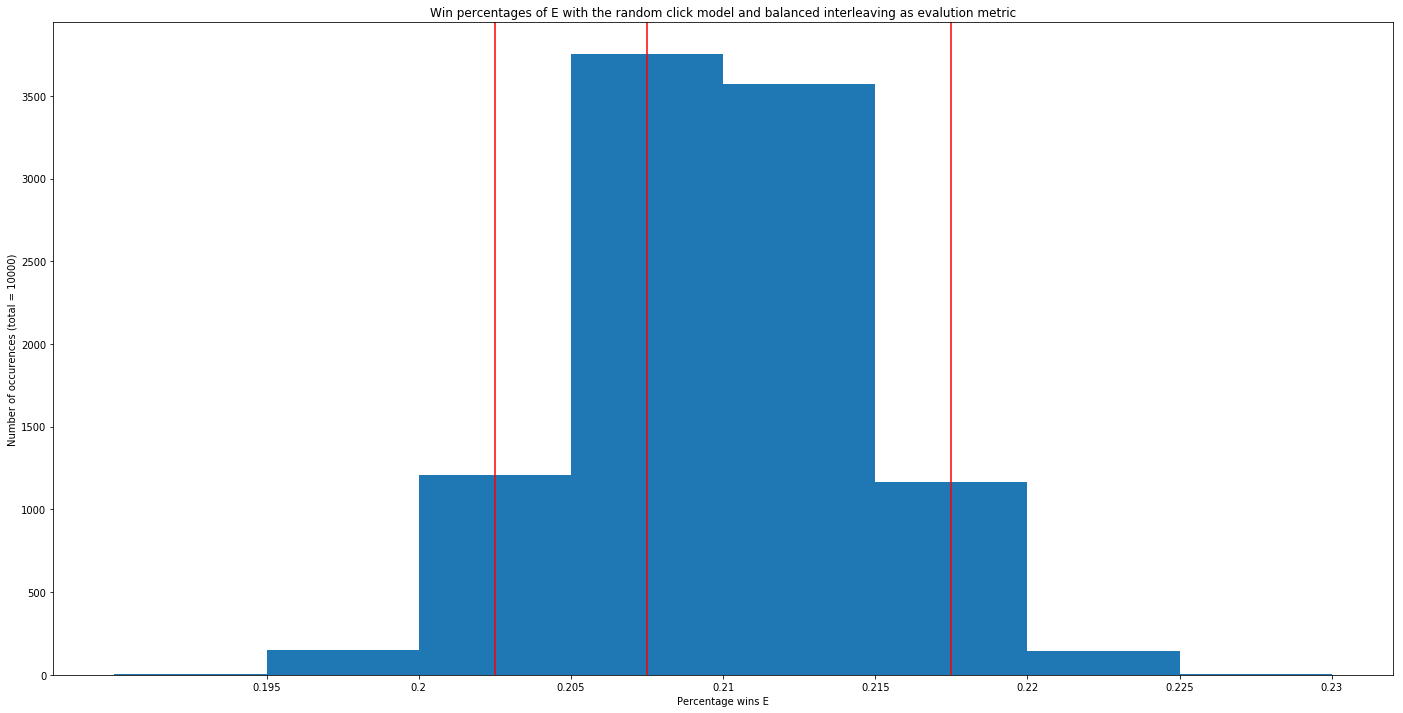

Win percentages of E with a random click model and balanced interleaving interleaving has a 95.0% confidence interval between: 20.5% and 22.0%, with the bootstrapped mean at 0.212


In [240]:
fig, ax = plt.subplots(figsize=(24, 12))


# Create graph attributes:
stats = list(bootstrapping_data["balanced"]["wins_random"].elements())

alpha = 0.95
p = ((1.0-alpha)/2.0) * 100
lower = max(0.0, np.percentile(stats, p))
p = (alpha+((1.0-alpha)/2.0)) * 100
upper = min(1.0, np.percentile(stats, p))
mean = np.mean(stats)
mean_idx = sorted(list(bootstrapping_data["balanced"]["wins_random"].keys())).index(myround(round(mean, 3)))
lower_idx = sorted(list(bootstrapping_data["balanced"]["wins_random"].keys())).index(myround(round(lower, 3)))
upper_idx = sorted(list(bootstrapping_data["balanced"]["wins_random"].keys())).index(myround(round(upper, 3)))

labels, values = zip(*sorted(bootstrapping_data["balanced"]["wins_random"].items()))

indexes = np.arange(len(labels))
width = 1

plt.axvline(mean_idx, color='r')
plt.axvline(lower_idx, color='r')
plt.axvline(upper_idx, color='r')

plt.bar(indexes, values, width)
plt.xticks(indexes + width * 0.5, labels)


ax.set_xlabel('Percentage wins E') 
ax.set_ylabel('Number of occurences (total = 10000)')
ax.set_title('Win percentages of E with the random click model and balanced interleaving as evalution metric')
plt.show()
print('Win percentages of E with a random click model and balanced interleaving interleaving has a %.1f%% confidence interval between: %.1f%% and %.1f%%, with the bootstrapped mean at %.3f' % (alpha*100, lower*100, upper*100, mean))

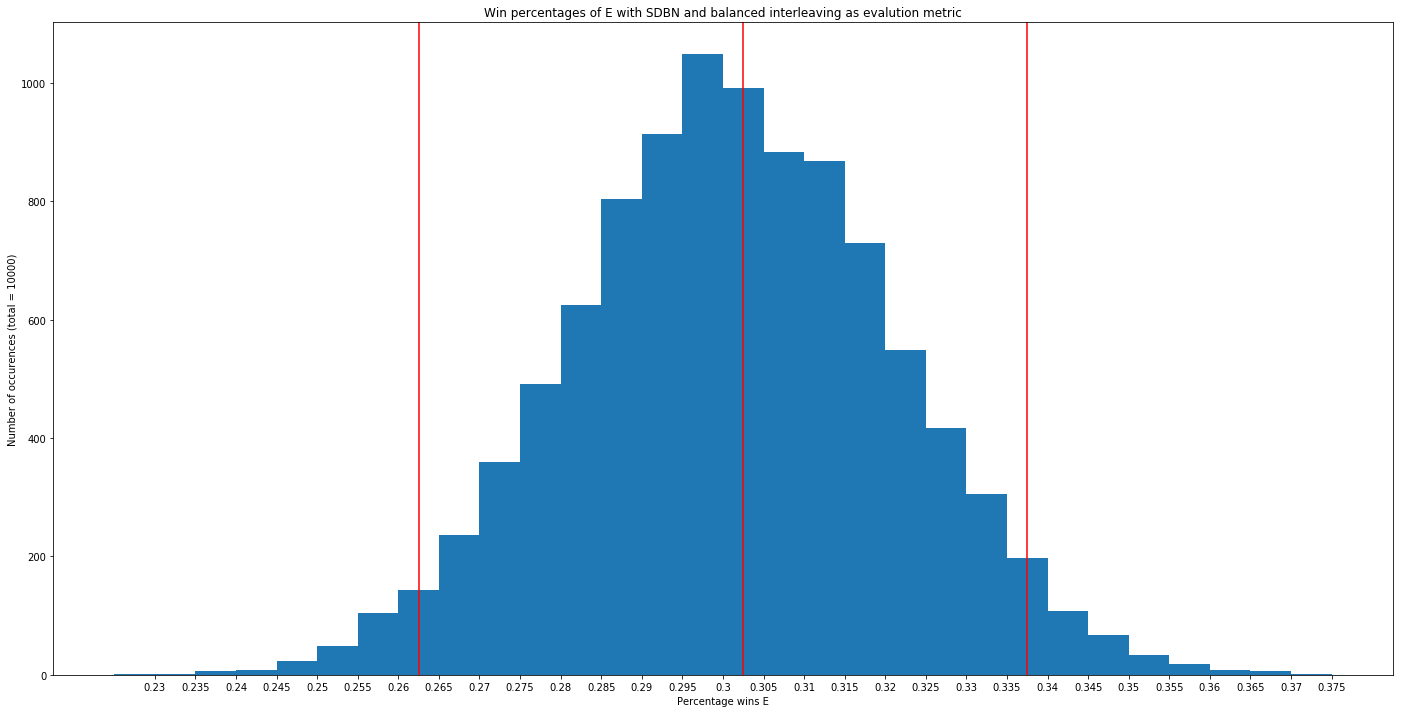

Win percentages of E with SDBN and balanced interleaving has a 95.0 confidence interval 26.5% and 34.0%, with mean at 0.304


In [237]:
fig, ax = plt.subplots(figsize=(24, 12))


# Create graph attributes:
stats = list(bootstrapping_data["balanced"]["wins_sdbn"].elements())

alpha = 0.95
p = ((1.0-alpha)/2.0) * 100
lower = max(0.0, np.percentile(stats, p))
p = (alpha+((1.0-alpha)/2.0)) * 100
upper = min(1.0, np.percentile(stats, p))
mean = np.mean(stats)
mean_idx = sorted(list(bootstrapping_data["balanced"]["wins_sdbn"].keys())).index(myround(round(mean, 3)))
lower_idx = sorted(list(bootstrapping_data["balanced"]["wins_sdbn"].keys())).index(myround(round(lower, 3)))
upper_idx = sorted(list(bootstrapping_data["balanced"]["wins_sdbn"].keys())).index(myround(round(upper, 3)))

labels, values = zip(*sorted(bootstrapping_data["balanced"]["wins_sdbn"].items()))

indexes = np.arange(len(labels))
width = 1

plt.axvline(mean_idx, color='r')
plt.axvline(lower_idx, color='r')
plt.axvline(upper_idx, color='r')

plt.bar(indexes, values, width)
plt.xticks(indexes + width * 0.5, labels)


ax.set_xlabel('Percentage wins E') 
ax.set_ylabel('Number of occurences (total = 10000)')
ax.set_title('Win percentages of E with SDBN and balanced interleaving as evalution metric')
plt.show()
print('Win percentages of E with a SDBN and balanced interleaving has a %.1f%% confidence interval between: %.1f%% and %.1f%%, with mean at %.3f' % (alpha*100, lower*100, upper*100, mean))

### Analyses plots and confidence intervals

the 

### Mean testing
To be able to do a t-test we must first confirm that the data follows a normal distribution. For this purpose the Omnibus test by D'agostino and Pearson is used. The experimental data is generated with an N=100, meaning 100 experiments for all interleaved rankings per click model are simulated.

(D’Agostino, R. and Pearson, E. S. (1973), “Testing for departures from normality,” Biometrika, 60, 613-622)

In [195]:
import random
import scipy.stats as stats

# Test if data is normaliy distributed

print('For the win percentages of .format{}')






# print('For the sdbn the normality test gives a p-value of 0.0, meaning that (using an alpha of 0.05) the hypothesis that the distibution of the data comes from a normal distribution is rejected:\n\n ',stats.mstats.normaltest(E_win_proportions['sdbn'], axis=0))
# print('\n')
# print('The same holds for data generated by the random click model: \n\n',stats.mstats.normaltest(E_win_proportions['random'], axis=0))
# print('\n\n For both clickmodels it thus does not make sense to use a t-test')

KeyError: 'sdbn'